# MODEL TO PREDICT ATTACKS

## Import dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from ipaddress import ip_address
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report

## Load data

In [2]:
df = pd.read_csv("./dataset/attacks.csv")
df.head()

,IP,Protocol,Attack Type,DateTime,Interactions,Port,Severity,Response Time,Packet Size,Origin Country,Detected By
0,192.168.1.1,FTP,Brute Force,2025-02-12 10:46:52,243,21,High,41,438,USA,Firewall
1,192.168.100.10,UDP,Malware,2025-02-12 10:46:52,166,123,High,294,1093,China,Antivirus
2,172.20.30.40,DNS,DNS Spoofing,2025-02-12 10:46:52,93,53,Medium,150,574,Germany,IDS
3,172.16.5.3,DNS,DNS Spoofing,2025-02-12 10:46:52,44,53,Medium,184,203,France,IDS
4,198.51.100.5,ICMP,Ping Flood,2025-02-12 10:46:52,318,0,Medium,542,1088,India,IPS


## Process data

Remove DateTime column

In [3]:
df.drop(columns=["DateTime", "Origin Country"], inplace=True)
df

,IP,Protocol,Attack Type,Interactions,Port,Severity,Response Time,Packet Size,Detected By
0,192.168.1.1,FTP,Brute Force,243,21,High,41,438,Firewall
1,192.168.100.10,UDP,Malware,166,123,High,294,1093,Antivirus
2,172.20.30.40,DNS,DNS Spoofing,93,53,Medium,150,574,IDS
3,172.16.5.3,DNS,DNS Spoofing,44,53,Medium,184,203,IDS
4,198.51.100.5,ICMP,Ping Flood,318,0,Medium,542,1088,IPS
...,...,...,...,...,...,...,...,...,...
19995,192.168.100.10,FTP,Malware,199,21,High,300,631,Antivirus
19996,192.168.100.10,UDP,Malware,149,68,High,150,1027,Antivirus
19997,192.168.1.1,SSH,Brute Force,136,22,High,94,446,Firewall
19998,192.168.100.10,TCP,Port Scanning,58,22,Medium,62,441,IDS


Convert IP into a numerical value

In [4]:
def convertir_ip(df):
    df['IP'] = df['IP'].apply(lambda x: int(ip_address(x)))
    return df

In [5]:
df = convertir_ip(df)
df.head()

,IP,Protocol,Attack Type,Interactions,Port,Severity,Response Time,Packet Size,Detected By
0,3232235777,FTP,Brute Force,243,21,High,41,438,Firewall
1,3232261130,UDP,Malware,166,123,High,294,1093,Antivirus
2,2886999592,DNS,DNS Spoofing,93,53,Medium,150,574,IDS
3,2886731011,DNS,DNS Spoofing,44,53,Medium,184,203,IDS
4,3325256709,ICMP,Ping Flood,318,0,Medium,542,1088,IPS


Convert categorical values into numerical

In [6]:
protocol_encoder = LabelEncoder()
severity_encoder = LabelEncoder()
detected_encoder = LabelEncoder()

df["Protocol"] = protocol_encoder.fit_transform(df["Protocol"])
df["Severity"] = severity_encoder.fit_transform(df["Severity"])
df["Detected By"] = detected_encoder.fit_transform(df["Detected By"])


df.head()

,IP,Protocol,Attack Type,Interactions,Port,Severity,Response Time,Packet Size,Detected By
0,3232235777,1,Brute Force,243,21,1,41,438,1
1,3232261130,7,Malware,166,123,1,294,1093,0
2,2886999592,0,DNS Spoofing,93,53,2,150,574,2
3,2886731011,0,DNS Spoofing,44,53,2,184,203,2
4,3325256709,4,Ping Flood,318,0,2,542,1088,3


Export encoders

In [7]:
joblib.dump(protocol_encoder, './model/protocol_encoder.joblib')
joblib.dump(severity_encoder, './model/severity_encoder.joblib')
joblib.dump(detected_encoder, './model/detected_encoder.joblib')

['./model/detected_encoder.joblib']

Scale data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Lista de columnas a escalar (sin "Attack Type")
columns_to_scale = ["IP", "Protocol","Interactions", "Port", "Severity", "Response Time", "Packet Size", "Detected By"]

# Aplicar StandardScaler solo a las columnas seleccionadas
df_scaled = scaler.fit_transform(df[columns_to_scale])

# Convertir los datos escalados en un DataFrame
df_processed = pd.DataFrame(df_scaled, columns=columns_to_scale)

# Agregar la columna "Attack Type" sin modificar
df_processed["Attack Type"] = df["Attack Type"].values

# Mostrar las primeras filas del DataFrame procesado
df_processed.head()


,IP,Protocol,Interactions,Port,Severity,Response Time,Packet Size,Detected By,Attack Type
0,0.698122,-1.096081,0.739323,-0.549815,0.071656,-0.809693,-0.864140,-0.828832,Brute Force
1,0.698140,1.518980,0.071443,0.151171,0.071656,-0.281693,0.715904,-1.572413,Malware
2,0.450010,-1.531924,-0.561741,-0.329898,1.463033,-0.582215,-0.536069,-0.085252,DNS Spoofing
3,0.449817,-1.531924,-0.986756,-0.329898,1.463033,-0.511259,-1.431025,-0.085252,DNS Spoofing
4,0.764973,0.211449,1.389855,-0.694136,1.463033,0.235872,0.703843,0.658329,Ping Flood


Exportar scaler

In [9]:
joblib.dump(scaler,'./model/scaler.joblib')

['./model/scaler.joblib']

## Model trainning

In [10]:
X = df_processed[["IP", "Protocol","Interactions", "Port", "Severity", "Response Time", "Packet Size", "Detected By"]]
y = df_processed[["Attack Type"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### KNN ALGORITHM

/home/criggio/github/workshop_gradiant/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/criggio/github/workshop_gradiant/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/criggio/github/workshop_gradiant/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/criggio/github/workshop_gradiant/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:2

[np.float64(0.9823999999999999), np.float64(0.9831), np.float64(0.9839), np.float64(0.9836500000000001), np.float64(0.9846499999999999), np.float64(0.98505), np.float64(0.98505), np.float64(0.9843999999999999), np.float64(0.9851000000000001), np.float64(0.98515), np.float64(0.9854499999999999), np.float64(0.9853999999999999), np.float64(0.9853999999999999), np.float64(0.9854499999999999), np.float64(0.9853), np.float64(0.9855), np.float64(0.9857000000000001), np.float64(0.9856999999999999), np.float64(0.9855), np.float64(0.9853)]


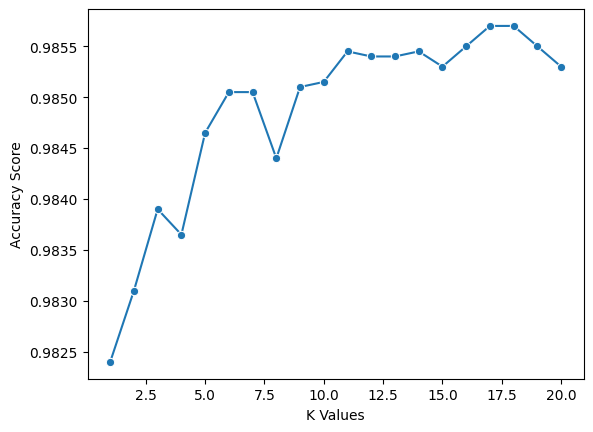

In [11]:
k_values = [i for i in range (1,21)]
scores = []

skf = StratifiedKFold(n_splits=5)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=skf)
    scores.append(np.mean(score))
    
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

print(scores)

In [12]:
# Entrenar el modelo KNN
neightrain = KNeighborsClassifier(n_neighbors=17).fit(X_train, y_train)


# Realizar la validación cruzada
skf = StratifiedKFold(n_splits=5)

y_pred_KNN = cross_val_predict(neightrain, X, y, cv=skf)
print("\nReporte completo:")
print(classification_report(y, y_pred_KNN))

/home/criggio/github/workshop_gradiant/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/criggio/github/workshop_gradiant/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/criggio/github/workshop_gradiant/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/criggio/github/workshop_gradiant/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:2


Reporte completo:
                      precision    recall  f1-score   support

         Brute Force       0.94      0.98      0.96      3341
Cross-Site Scripting       1.00      1.00      1.00      1222
                DDoS       1.00      1.00      1.00      3270
   DNS Amplification       1.00      1.00      1.00      1216
        DNS Spoofing       1.00      1.00      1.00      1261
             Malware       1.00      1.00      1.00      2506
   Man-in-the-Middle       1.00      1.00      1.00      1242
          Ping Flood       1.00      1.00      1.00      1314
       Port Scanning       1.00      1.00      1.00       880
       SQL Injection       1.00      1.00      1.00      1269
 Unauthorized Access       0.95      0.82      0.88      1284
            Zero-Day       1.00      1.00      1.00      1195

            accuracy                           0.99     20000
           macro avg       0.99      0.98      0.99     20000
        weighted avg       0.99      0.99      0.

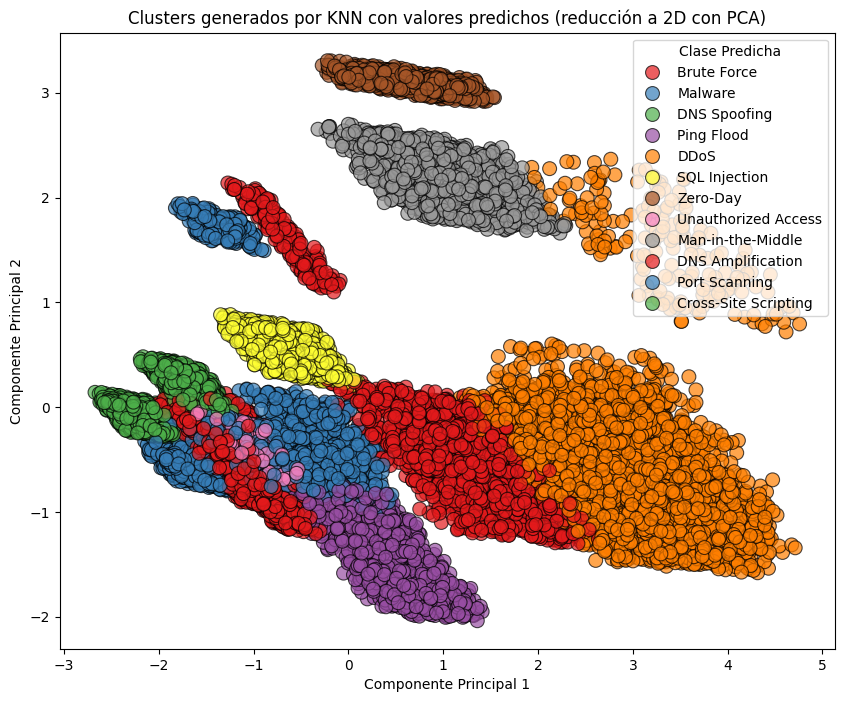

In [13]:
# Reducir la dimensionalidad de X a 2D con PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(10, 8))

# Usamos seaborn para un gráfico más bonito
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_pred_KNN, palette="Set1", s=100, edgecolor='k', alpha=0.7)

# Añadir solo la leyenda de clases sin etiquetas para cada punto
plt.title("Clusters generados por KNN con valores predichos (reducción a 2D con PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clase Predicha", loc='upper right')

# Mostrar el gráfico
plt.show()


Exportar KNN

In [14]:
joblib.dump(neightrain,'./model/knn_model.joblib')

['./model/knn_model.joblib']